# COVID-19 in Manaus

# Analysis and Forecasting

This notebook was an exercise based on methodology from the book of Jason Brownlee, Introduction to Time Series Forecasting with Python.

## Initial Setup

In [1]:
# check the versions of key python libraries 

#import scipy
#print('scipy: %s' % scipy.__version__)

import numpy as np
print('numpy: %s' % np.__version__)

import matplotlib.pyplot as plt
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)

import seaborn as sns
%matplotlib inline
print('seaborn: %s' % sns.__version__)

import pandas as pd
print('pandas: %s' % pd.__version__)
from pandas.plotting import autocorrelation_plot

import statsmodels
print('statsmodels: %s' % statsmodels.__version__) # scikit-learn

import sklearn
print('sklearn: %s' % sklearn.__version__)

from sklearn.metrics import mean_squared_error

from tqdm import tqdm
#import requests
import zipfile

import warnings
warnings.filterwarnings("ignore")

#import gc

!python --version


#pd.set_option('max_columns', 50)
pd.set_option('max_rows', 200)

numpy: 1.17.2
matplotlib: 3.1.1
seaborn: 0.9.0
pandas: 0.25.1
statsmodels: 0.10.1
sklearn: 0.21.3
Python 3.7.4


In [2]:
# data folders
data_dir = './data/'
models_dir = './models/'
data_zip = './data_zip/'

In [3]:
# download file
# source:
# https://www.kaggle.com/unanimad/corona-virus-brazil

print('downloading file .zip ...')
print()
!kaggle datasets download unanimad/corona-virus-brazil --force
print()
print('download finished!')
print()

with zipfile.ZipFile('corona-virus-brazil.zip', 'r') as zip_ref:
    zip_ref.extractall(data_dir)
print('unziped!')

downloading file .zip ...

 67%|█████████████████████████▌            | 1.00M/1.49M [00:00<00:00, 2.77MB/s]
100%|██████████████████████████████████████| 1.49M/1.49M [00:00<00:00, 3.49MB/s]

download finished!

unziped!


In [4]:
import os

#from datetime import date
#date_today = str(date.today())

if not os.path.exists(models_dir):
    os.mkdir(models_dir)
    print("Directory " , models_dir ,  " Created ")
else:    
    print("Directory " , models_dir ,  " already exists")

if not os.path.exists(data_zip):
    os.mkdir(data_zip)
    print("Directory " , data_zip ,  " Created ")
else:    
    print("Directory " , data_zip ,  " already exists")
    
os.rename("./corona-virus-brazil.zip", data_zip+"corona-virus-brazil.zip")

Directory  ./models/  already exists
Directory  ./data_zip/  already exists


In [5]:
print("Files:")
!ls {data_dir}

Files:
brazil_cities_coordinates.csv brazil_population_2019.csv
brazil_covid19.csv            dataset.csv
brazil_covid19_cities.csv     stationary.csv
brazil_covid19_macro.csv      validation.csv
brazil_covid19_old.csv


In [6]:
covid_br = pd.read_csv(data_dir + 'brazil_covid19.csv')
print('Covid BR has {} rows and {} columns'.format(covid_br.shape[0], covid_br.shape[1]))
print()
print('Last information in ' + covid_br.iloc[-1,0])


Covid BR has 2087 rows and 5 columns

Last information in 2020-05-29


In [7]:
covid_br.head()

,date,region,state,cases,deaths
0,2020-02-26,Sudeste,São Paulo,1,0
1,2020-02-27,Sudeste,São Paulo,1,0
2,2020-02-28,Sudeste,São Paulo,1,0
3,2020-02-29,Sudeste,São Paulo,2,0
4,2020-03-01,Sudeste,São Paulo,2,0


In [8]:
covid_br.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2087 entries, 0 to 2086
Data columns (total 5 columns):
date      2087 non-null object
region    2087 non-null object
state     2087 non-null object
cases     2087 non-null int64
deaths    2087 non-null int64
dtypes: int64(2), object(3)
memory usage: 81.6+ KB


In [9]:
# Select only Amazonas

df = covid_br[covid_br["state"] == "Amazonas"]
df.tail(5)

,date,region,state,cases,deaths
1967,2020-05-25,Norte,Amazonas,30282,1781
1994,2020-05-26,Norte,Amazonas,31949,1852
2021,2020-05-27,Norte,Amazonas,33508,1891
2048,2020-05-28,Norte,Amazonas,36146,1964
2075,2020-05-29,Norte,Amazonas,38909,2011


In [10]:
df.shape

(76, 5)

In [11]:
df.describe()

,cases,deaths
count,76.000000,76.000000
mean,8085.539474,538.447368
std,10682.553976,649.615217
min,1.000000,0.000000
25%,252.250000,6.000000
50%,2374.500000,200.000000
75%,12679.000000,1011.750000
max,38909.000000,2011.000000


## Initial Feature Engineering

In [12]:
# datetime
df['date'] = pd.to_datetime(df['date'])

# day of week
df['day_of_week'] = df['date'].dt.day_name()
df['day_of_week_n'] = df['date'].dt.dayofweek  #Monday=0, Sunday=6.

# set index
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index, format="%Y-%m-%d")
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 76 entries, 2020-03-15 to 2020-05-29
Data columns (total 6 columns):
region           76 non-null object
state            76 non-null object
cases            76 non-null int64
deaths           76 non-null int64
day_of_week      76 non-null object
day_of_week_n    76 non-null int64
dtypes: int64(3), object(3)
memory usage: 4.2+ KB


In [13]:
# creating month and day
df['month'] = [df.index[i].month for i in range(len(df))]
df['day'] = [df.index[i].day for i in range(len(df))] 

# creating death by day
df['deaths_d'] = df['deaths'] - df['deaths'].shift(1)


# drop
df.drop(['region'], axis = 1, inplace = True)
df.drop(['state'], axis = 1, inplace = True)
df.drop(['cases'], axis = 1, inplace = True)

# deleting "deaths = 0"
df = df[df["deaths"] > 0]

# week
df['week'] = [df.index[i].week for i in range(len(df))]
first_week = df.iloc[0, -1] 
df['week'] = df['week'].astype(int) - first_week +1 

df.tail(2)

,deaths,day_of_week,day_of_week_n,month,day,deaths_d,week
date,,,,,,,
2020-05-28,1964,Thursday,3,5,28,73.0,10
2020-05-29,2011,Friday,4,5,29,47.0,10


## Data Analysis

### Components of Time Series

Time series analysis provides a body of techniques to better understand a dataset. Perhaps the most useful of these is the decomposition of a time series into 4 constituent parts:

- Level. The baseline value for the series if it were a straight line.

- Trend. The optional and often linear increasing or decreasing behavior of the series over time.
􏰀
- Seasonality. The optional repeating patterns or cycles of behavior over time.

- Noise. The optional variability in the observations that cannot be explained by the model.


p.11

### Concerns of Forecasting

When forecasting, it is important to understand your goal. Use the Socratic method and ask lots of questions to help zoom in on the specifics of your predictive modeling problem. For example:

1. How much data do you have available and are you able to gather it all together? More data is often more helpful, offering greater opportunity for exploratory data analysis, model testing and tuning, and model fidelity.

2. What is the time horizon of predictions that is required? Short, medium or long term? Shorter time horizons are often easier to predict with higher confidence.

3. Can forecasts be updated frequently over time or must they be made once and remain static? Updating forecasts as new information becomes available often results in more accurate predictions.

4. At what temporal frequency are forecasts required? Often forecasts can be made at a lower or higher frequencies, allowing you to harness down-sampling, and up-sampling of data, which in turn can offer benefits while modeling.


Time series data often requires cleaning, scaling, and even transformation. For example:

- Frequency. Perhaps data is provided at a frequency that is too high to model or is unevenly spaced through time requiring resampling for use in some models.

- Outliers. Perhaps there are corrupt or extreme outlier values that need to be identified and handled.

- Missing. Perhaps there are gaps or missing data that need to be interpolated or imputed.

p.12

______

- Sliding Window, p.15

- Sliding Window With Multivariates, p.16

- Sliding Window With Multiple Steps, p.18

- Lag Features, p.29: X.shift(1)

- Rolling Window Statistics, p.31: rolling(X).mean()

        width = 3
        shifted = temps.shift(width - 1)
        window = shifted.rolling(window=width)
        dataframe = concat([window.min(), window.mean(), window.max(), temps], axis=1) dataframe.columns = ['min', 'mean', 'max', 't+1']


- Expanding Window Statistics, p.33: expanding()

        temps = DataFrame(series.values)
        window = temps.expanding()
        dataframe = concat([window.min(), window.mean(), window.max(), temps.shift(-1)], axis=1) dataframe.columns = ['min', 'mean', 'max', 't+1']


### Summary Statistics

In [14]:
# Number of Observations
df.shape

(66, 7)

In [15]:
df.head()

,deaths,day_of_week,day_of_week_n,month,day,deaths_d,week
date,,,,,,,
2020-03-25,1,Wednesday,2,3,25,1.0,1
2020-03-26,1,Thursday,3,3,26,0.0,1
2020-03-27,1,Friday,4,3,27,0.0,1
2020-03-28,1,Saturday,5,3,28,0.0,1
2020-03-29,1,Sunday,6,3,29,0.0,1


In [16]:
# Descriptive Statistics
df[["deaths", "deaths_d"]].describe()

,deaths,deaths_d
count,66.000000,66.000000
mean,620.030303,30.469697
std,659.970372,27.360398
min,1.000000,0.000000
25%,50.750000,7.250000
50%,312.000000,21.000000
75%,1144.500000,48.500000
max,2011.000000,102.000000


### Line Plot

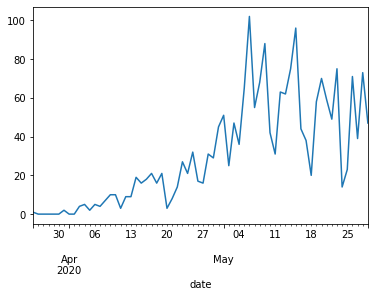

In [17]:
df["deaths_d"].plot()
plt.show()

- Increasing trend of cases over time.
- There do not appears to be systematic seasonality to the cases for each day.
- There do not appear to be any obvious outliers.

### Histogram and Density Plot

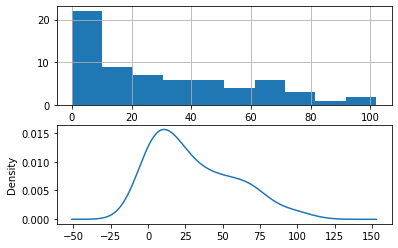

In [18]:
plt.figure(1)
plt.subplot(211)
df["deaths_d"].hist()

plt.subplot(212)
df["deaths_d"].plot(kind='kde')
plt.show()

- The distribution is not Guassian.
- The shape has a long right rail and may suggest an exponential distribution.

### Box and Whisker Plots

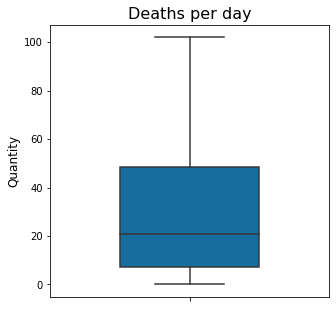

In [19]:
plt.figure(figsize=(5,5))
bplot = sns.boxplot(y='deaths_d', 
                 data=df, 
                 width=0.5,
                 palette="colorblind")

bplot.axes.set_title("Deaths per day", fontsize=16)
bplot.set_xlabel(" ", fontsize=12)
bplot.set_ylabel("Quantity", fontsize=12)
bplot.tick_params(labelsize=10)

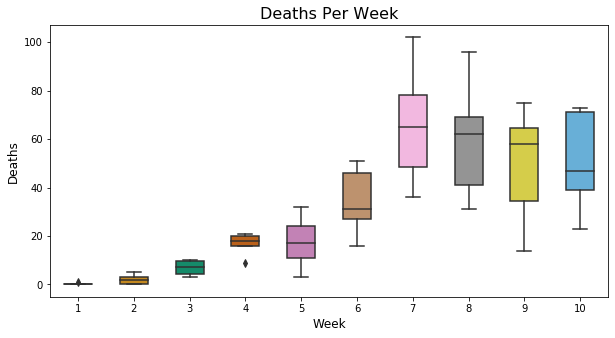

In [20]:
plt.figure(figsize=(10,5))
bplot = sns.boxplot(y='deaths_d', x='week', data=df,
                    width=0.5, palette="colorblind")

bplot.axes.set_title("Deaths Per Week", fontsize=16)
bplot.set_xlabel("Week", fontsize=12)
bplot.set_ylabel("Deaths", fontsize=12)
bplot.tick_params(labelsize=10)

# output file name
#plot_file_name="boxplot.jpg"
 
# save as jpeg
#bplot.figure.savefig(plot_file_name, format='jpeg', dpi=100)

### Heat Maps

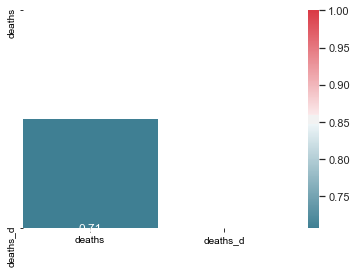

In [21]:
# Analysing correlations

corr = df[["deaths", "deaths_d"]].corr()
fig, ax = plt.subplots(figsize=(6, 4))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
   
dropSelf = np.zeros_like(corr)
dropSelf[np.triu_indices_from(dropSelf)] = True

sns.set()
sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf)

plt.show()

### Lag Scatter Plots

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


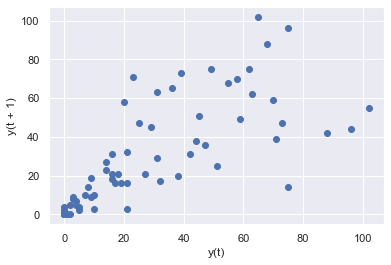

In [22]:
from pandas.plotting import lag_plot
lag_plot(df["deaths_d"])
plt.show()

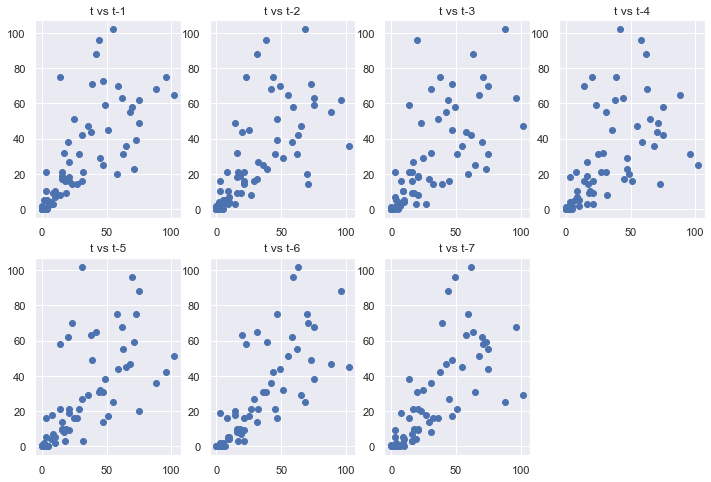

In [23]:
from pandas import concat

lags = 7
columns = [df["deaths_d"]]

for i in range(1,(lags + 1)):
    columns.append(df["deaths_d"].shift(i))

dataframe = concat(columns, axis=1) 
columns = ['t']

for i in range(1,(lags + 1)):
    columns.append('t-' + str(i)) 

dataframe.columns = columns 
plt.figure(1, figsize=(12, 8))

for i in range(1,(lags + 1)):
    ax = plt.subplot(240 + i)
    ax.set_title('t vs t-' + str(i))
    plt.scatter(x=dataframe['t'].values, y=dataframe['t-'+str(i)].values)
plt.show()

### Correlation

In [24]:
values =  pd.DataFrame(df["deaths_d"])
dataframe = concat([values.shift(1), values], axis=1) 
dataframe.columns = ['t', 't+1']
result = dataframe.corr()
print(result)

            t       t+1
t    1.000000  0.725492
t+1  0.725492  1.000000


### Autocorrelation

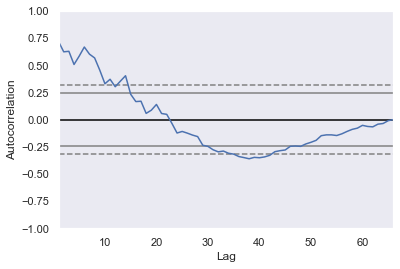

In [25]:
# autocorrelation
autocorrelation_plot(df["deaths_d"])
plt.show()

## Test Harness

### Validation Dataset

In [26]:
# split into a training and validation dataset
#from pandas import read_csv

series = df["deaths_d"]
split_point = round(len(series) * 0.9)
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation))) 

dataset.to_csv(data_dir + 'dataset.csv')
validation.to_csv(data_dir + 'validation.csv')

Dataset 59, Validation 7


### Prepare Data

In [27]:
X = dataset.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

print('train %d, test %d' % (len(train), len(test)))

train 29, test 30


### Persistence - Base Line Model

In [28]:
# evaluate a persistence model

#from pandas import read_csv
#from sklearn.metrics import mean_squared_error
#from math import sqrt

# walk-forward validation
history = [x for x in train]
predictions = list()

for i in range(len(test)):
    
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

    # report performance
persistence_rmse = np.sqrt(mean_squared_error(test, predictions)) 
print('RMSE: %.3f' % persistence_rmse)

>Predicted=14.000, Expected= 27
>Predicted=27.000, Expected= 21
>Predicted=21.000, Expected= 32
>Predicted=32.000, Expected= 17
>Predicted=17.000, Expected= 16
>Predicted=16.000, Expected= 31
>Predicted=31.000, Expected= 29
>Predicted=29.000, Expected= 45
>Predicted=45.000, Expected= 51
>Predicted=51.000, Expected= 25
>Predicted=25.000, Expected= 47
>Predicted=47.000, Expected= 36
>Predicted=36.000, Expected= 65
>Predicted=65.000, Expected=102
>Predicted=102.000, Expected= 55
>Predicted=55.000, Expected= 68
>Predicted=68.000, Expected= 88
>Predicted=88.000, Expected= 42
>Predicted=42.000, Expected= 31
>Predicted=31.000, Expected= 63
>Predicted=63.000, Expected= 62
>Predicted=62.000, Expected= 75
>Predicted=75.000, Expected= 96
>Predicted=96.000, Expected= 44
>Predicted=44.000, Expected= 38
>Predicted=38.000, Expected= 20
>Predicted=20.000, Expected= 58
>Predicted=58.000, Expected= 70
>Predicted=70.000, Expected= 59
>Predicted=59.000, Expected= 49
RMSE: 23.157


## ARIMA Models

### Create a differenced time series

ADF Statistic: -6.542697
p-value: 0.000000
Critical Values:
	1%: -3.560
	5%: -2.918
	10%: -2.597


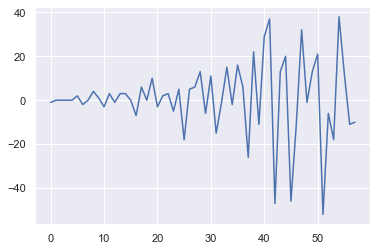

In [29]:
# statistical test for the stationarity of the time series
#from pandas import read_csv
#from pandas import Series
from statsmodels.tsa.stattools import adfuller

# create a differenced time series
def difference(data):
    diff = list()
    for i in range(1, len(data)):
        value = data[i] - data[i - 1]
        diff.append(value)
    return pd.Series(diff)



# series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True) X = series.values
# X = series.values

# difference data
stationary = difference(dataset)
#stationary.index = series.index[1:]

# check if stationary
def adf(X):
    result = adfuller(X) 
    print('ADF Statistic: %f' % result[0]) 
    print('p-value: %f' % result[1]) 
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value)) 
    return None

adf(stationary)

plt.plot(stationary)
plt.show()

# save
stationary.to_csv(data_dir + 'stationary.csv')

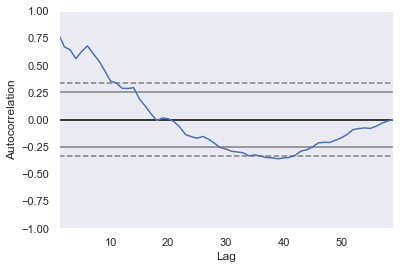

In [30]:
 # autocorrelation plot
autocorrelation_plot(dataset)
plt.show()

- there are high correlations before day 3.

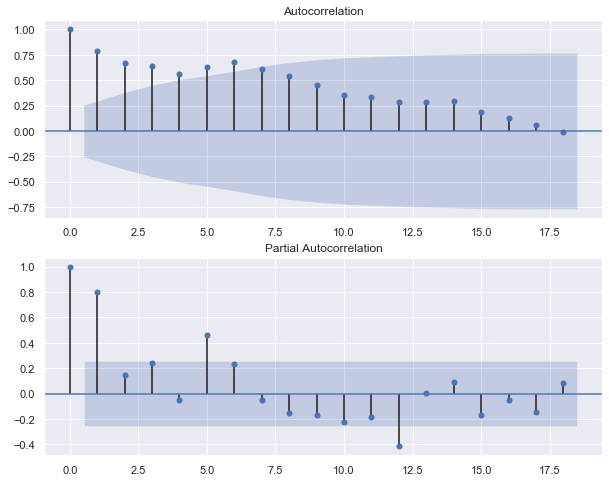

In [31]:
# ACF and PACF plots of time series
#from pandas import read_csv
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
#from matplotlib import pyplot

def acf_pacf(X):
    plt.figure(figsize=(10,8))
    plt.subplot(211)
    plot_acf(X, ax=plt.gca())
    plt.subplot(212)
    plot_pacf(X, ax=plt.gca())
    plt.show()
    return None

acf_pacf(dataset)

In [36]:
from statsmodels.tsa.arima_model import ARIMA

# ARIMA
p = 3   # Autocorrelation Function (ACF)

d = 1   # level of differencing

q = 1   # Partial Autocorrelation Function (PACF)

In [37]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    model = ARIMA(history, order=(p,d,q))
    model_fit = model.fit(disp=0)
    yhat = int(model_fit.forecast()[0])
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

>Predicted=18.000, Expected= 27
>Predicted=26.000, Expected= 21
>Predicted=22.000, Expected= 32
>Predicted=20.000, Expected= 17
>Predicted=23.000, Expected= 16
>Predicted=14.000, Expected= 31
>Predicted=26.000, Expected= 29
>Predicted=28.000, Expected= 45
>Predicted=30.000, Expected= 51
>Predicted=45.000, Expected= 25
>Predicted=24.000, Expected= 47
>Predicted=34.000, Expected= 36
>Predicted=38.000, Expected= 65
>Predicted=45.000, Expected=102
>Predicted=93.000, Expected= 55
>Predicted=86.000, Expected= 68
>Predicted=79.000, Expected= 88
>Predicted=67.000, Expected= 42
>Predicted=70.000, Expected= 31
>Predicted=53.000, Expected= 63
>Predicted=46.000, Expected= 62
>Predicted=52.000, Expected= 75
>Predicted=78.000, Expected= 96
>Predicted=84.000, Expected= 44
>Predicted=60.000, Expected= 38
>Predicted=66.000, Expected= 20
>Predicted=8.000, Expected= 58
>Predicted=61.000, Expected= 70
>Predicted=64.000, Expected= 59
>Predicted=62.000, Expected= 49


RMSE: 24.753

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   57
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -233.296
Method:                       css-mle   S.D. of innovations             14.100
Date:                Sun, 31 May 2020   AIC                            478.591
Time:                        11:42:07   BIC                            490.849
Sample:                             1   HQIC                           483.355
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2982      0.187      6.959      0.000       0.933       1.664
ar.L1.D.y      0.4188      0.133      3.142      0.003       0.158       0.680
ar.L2.D.y     -0.0921      0.141     -

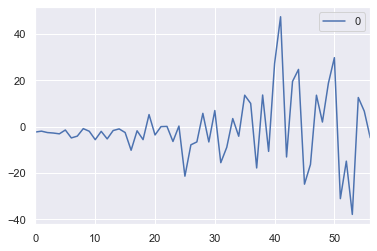

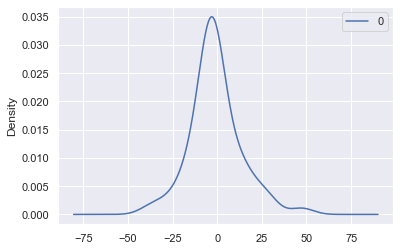

               0
count  57.000000
mean   -0.897147
std    14.363064
min   -37.813921
25%    -6.557833
50%    -2.298161
75%     5.235151
max    47.411698


In [38]:
# report performance
rmse = np.sqrt(mean_squared_error(test, predictions)) 
print('RMSE: %.3f' % rmse)
    
print()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid) 
residuals.plot()
plt.show()

# density plot of residuals residuals.plot(kind='kde') 
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
print(residuals.describe())

Note, that although above we used the entire dataset for time series analysis, ideally we would perform this analysis on just the training dataset when developing a predictive model.

### Grid Search ARIMA Hyperparameters

ARIMA(0, 0, 0) RMSE=37.332
ARIMA(0, 0, 1) RMSE=27.684
ARIMA(0, 0, 2) RMSE=29.022
ARIMA(0, 1, 0) RMSE=23.393
ARIMA(0, 1, 1) RMSE=23.094
ARIMA(0, 1, 2) RMSE=23.980
ARIMA(0, 2, 0) RMSE=36.954
ARIMA(0, 2, 1) RMSE=24.059
ARIMA(1, 0, 0) RMSE=23.372
ARIMA(1, 1, 0) RMSE=23.893
ARIMA(1, 1, 1) RMSE=23.039
ARIMA(1, 2, 0) RMSE=32.626
ARIMA(2, 0, 0) RMSE=23.548
ARIMA(2, 1, 0) RMSE=23.653
ARIMA(2, 2, 0) RMSE=29.185
ARIMA(3, 0, 0) RMSE=23.679
ARIMA(3, 1, 0) RMSE=24.717
ARIMA(3, 1, 1) RMSE=24.742
ARIMA(3, 2, 0) RMSE=30.566
ARIMA(4, 0, 0) RMSE=25.012
ARIMA(4, 1, 0) RMSE=24.013
ARIMA(4, 2, 0) RMSE=31.047
ARIMA(5, 0, 0) RMSE=24.811
ARIMA(5, 1, 0) RMSE=23.566
ARIMA(5, 2, 0) RMSE=27.526
Best ARIMA(1, 1, 1) RMSE=23.039


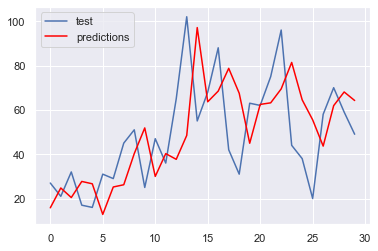

In [39]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE

def evaluate_arima_model(train, test, arima_order): # prepare training dataset
    #X = X.astype('float32')
    #train_size = int(len(X) * 0.70)
    #train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]

    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    
    # calculate out of sample error
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse, predictions

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, test, p_values, d_values, q_values): 
    #dataset = dataset.astype('float32')
    best_score, best_cfg, best_test, best_predictions = float("inf"), None, None, None
    for p in p_values:
        for d in d_values:
             for q in q_values:
                order = (p,d,q)
                try:
                    rmse, predictions = evaluate_arima_model(train, test, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                        best_predictions = predictions
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    
    # plot forecasts against actual outcomes 
    plt.plot(test, label="test")
    plt.plot(best_predictions, color='red', label="predictions") 
    plt.legend(loc="upper left")
    plt.show()
    
    return best_score, best_cfg, best_predictions
    

# load dataset
#series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True) # evaluate parameters
p_values = range(0, p+3) # add 2 to original/manual values
d_values = range(0, d+3)
q_values = range(0, q+3)

# execute
arima_score, best_cfg, best_predictions = evaluate_models(train, test, p_values, d_values, q_values) 

### Review Residual Errors

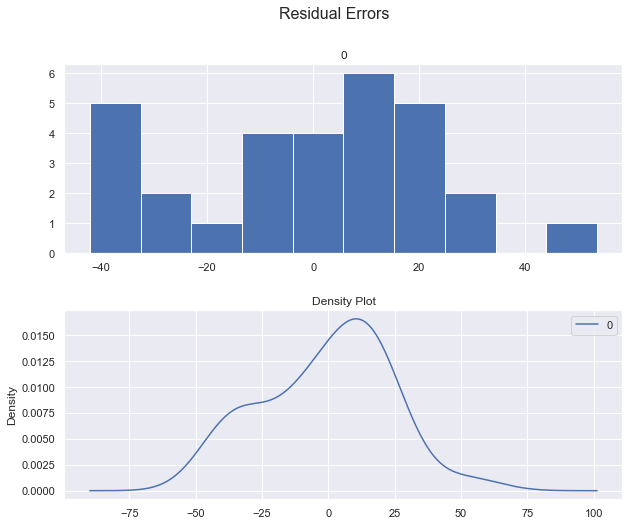

In [40]:
# errors
residuals = [test[i]-best_predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)



fig = plt.figure(figsize=(10,8))
fig.suptitle("Residual Errors", fontsize=16)
ax1 = fig.add_subplot(211)
ax1.title.set_text('Histogram')
ax1 = residuals.hist(ax=plt.gca())

ax2 = fig.add_subplot(212)
ax2.title.set_text('Density Plot')
ax2 = residuals.plot(kind='kde', ax=plt.gca()) 
plt.show();

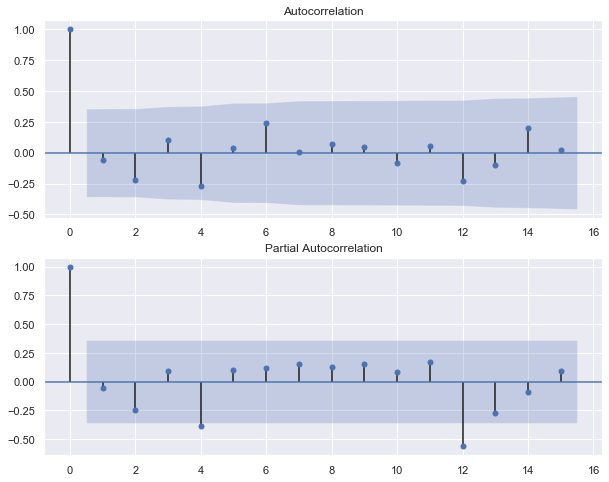

In [41]:
# residuals
acf_pacf(residuals)

### Box-Cox Transformed Dataset

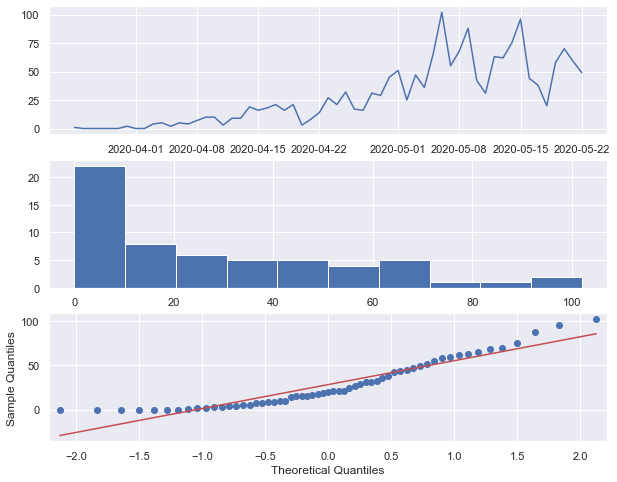

In [42]:
from statsmodels.graphics.gofplots import qqplot

# before transform

plt.figure(figsize=(10,8))

# line plot
plt.subplot(311)
plt.plot(dataset)
# histogram
plt.subplot(312)
plt.hist(dataset)
# q-q plot
plt.subplot(313)
qqplot(dataset, line='r', ax=plt.gca()) 
plt.show()

In [43]:
from scipy.stats import boxcox

# transformation pre because zeros into the dataset

def box_cox(X):
    X = pd.Series(X)
    posdata = X[X > 0]

    bcdata, lam = boxcox(posdata)

    transformed = np.empty_like(X)
    transformed[X > 0] = bcdata
    transformed[X == 0] = -1/lam
    return transformed, lam

transformed, lam = box_cox(dataset)
print('Lambda: %f' % lam)

Lambda: 0.319197


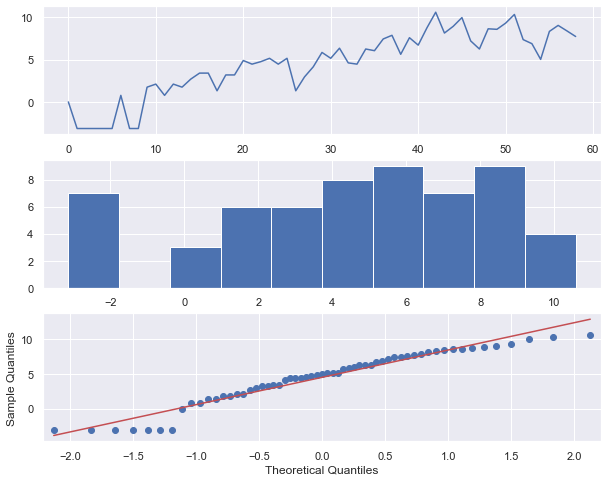

In [44]:
plt.figure(figsize=(10,8))

# line plot
plt.subplot(311)
plt.plot(transformed)
# histogram
plt.subplot(312)
plt.hist(transformed)
# q-q plot
plt.subplot(313)
qqplot(transformed, line='r', ax=plt.gca()) 
plt.show()

### ARIMA after box-cox tranformation

In [45]:
# invert box-cox transform
def boxcox_inverse(value, lam):
    if lam == 0:
        return np.exp(value)
    return np.exp(np.log(lam * value + 1) / lam)

# walk-forward validation
history = [x for x in train]
predictions = list()

for i in range(len(test)):
    # transform
    transformed, lam = box_cox(history)
    if lam < -5:
        transformed, lam = history, 1

    # predict
    model = ARIMA(transformed, order=(best_cfg)) # previous best_cfg
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    
    # invert transformed prediction
    yhat = boxcox_inverse(yhat, lam) 
    predictions.append(yhat)
    
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

# report performance
box_cox_rmse = np.sqrt(mean_squared_error(test, predictions)) 
print('RMSE: %.3f' % box_cox_rmse)

ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

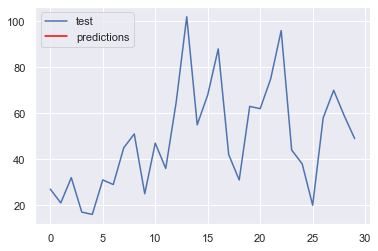

In [46]:
# plot forecasts against actual outcomes 
plt.plot(test, label="test")
plt.plot(predictions, color='red', label="predictions") 
plt.legend(loc="upper left")
plt.show()

In [47]:
# Compare scores

print('>Persistence score=%.3f' % (persistence_rmse))
print('>Previous ARIMA score=%.3f' % (arima_score))
print('>Box-Cox ARIMA score=%.3f' % (box_cox_rmse))

>Persistence score=23.157
>Previous ARIMA score=23.039


NameError: name 'box_cox_rmse' is not defined

## Model Validation

### Finalize Model

In [ ]:
# transform data
transformed, lam = box_cox(dataset) # all dataset

# fit model
model = ARIMA(transformed, order=(best_cfg)) 
model_fit = model.fit(disp=0)

# save model
model_fit.save(models_dir + 'model.pkl') 
np.save(models_dir + 'model_lambda.npy', [lam])

### Make Prediction

In [ ]:
from statsmodels.tsa.arima_model import ARIMAResults

model_fit = ARIMAResults.load(models_dir + 'model.pkl') 
lam = np.load(models_dir + 'model_lambda.npy')
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam) 
print('Predicted: %.3f' % yhat)

### Validate Model

In [ ]:
# load and prepare datasets

history = [x for x in dataset]
y = validation.values

# load model
model_fit = ARIMAResults.load(models_dir + 'model.pkl') 
lam = np.load(models_dir + 'model_lambda.npy')

# make first prediction
predictions = list()
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam) 
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0])) 

# rolling forecasts
for i in range(1, len(y)):
    # transform
    transformed, lam = box_cox(history)
    if lam < -5:
        transformed, lam = history, 1
    # predict
    model = ARIMA(transformed, order=(best_cfg))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    yhat = int(boxcox_inverse(yhat, lam))
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

# report performance
rmse = np.sqrt(mean_squared_error(y, predictions)) 
print('RMSE: %.3f' % rmse)
plt.plot(y)
plt.plot(predictions, color='red') 
plt.show()

### Seasonal Adjustment with Modeling

Coefficients: [-3.41322328e-10  8.68320451e-08 -8.81443459e-06  4.54905058e-04
 -1.26096351e-02  1.82277191e-01 -1.19735447e+00  2.90104454e+00
 -7.76475887e-01]


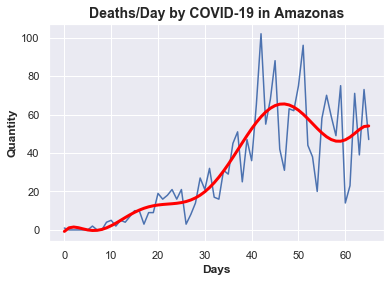

In [50]:
from numpy import polyfit

series = df["deaths_d"]

# fit polynomial: x^2*b1 + x*b2 + ... + bn
X = [i%365 for i in range(0, len(series))] 
y = series.values

degree = 8
coef = polyfit(X, y, degree) 
print('Coefficients: %s' % coef)

# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)

# plot curve over original data
plt.plot(series.values) 
plt.plot(curve, color='red', linewidth=3) 
plt.title('Deaths/Day by COVID-19 in Amazonas', weight='bold', size=14)
plt.ylabel('Quantity', weight='bold', size=12)
plt.xlabel('Days', weight='bold', size=12)
plt.show()